In [198]:
library(tidyverse)
library(cowplot)
library(UpSetR)

# NORM methods contains bugs!

# Load and Filter

In [213]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))



head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

In [214]:
PG_report <- read.table(
    "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Combined/proteinGroups.txt",
    header=T,
    sep="\t",
    stringsAsFactors = F)

dim(PG_report)

[1] 768 288

In [215]:
# # remove decoy matches and matches to contaminant
# PG_report <- PG_report[!PG_report$Reverse=="+",]
# PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
# # # Only.identified.by.site - exclude proteins that were only identified by a modification site
# PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]


# dim(PG_report)

#### intensities

In [216]:
# take only the columns that we need
pg_intensities <- PG_report %>%
    select(c("Majority.protein.IDs", "Peptide.sequences", rownames(metadata))) 
rownames(pg_intensities) <- pg_intensities$Majority.protein.IDs
pg_intensities$Majority.protein.IDs <- NULL

colnames(pg_intensities) <- c("Peptide.sequences", metadata$Quantitative.column.name)
dim(pg_intensities)

pg_intensities[pg_intensities==0] <- NA

# remove the rows with NA in all Quantitative columns
pg_intensities <- pg_intensities[!apply(pg_intensities[,2:dim(pg_intensities)[2]], 1, function(x) all(is.na(x))),]



# count the % of missing values
round(sum(is.na(pg_intensities)) * 100 / (dim(pg_intensities)[1] * dim(pg_intensities)[2]), 3)


[1] 768  66

[1] 23.694

In [217]:
head(pg_intensities, 3)

,Peptide.sequences,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,P_1.RIC_9,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Q9UBX1;A0A7I2V4A8;A0A7I2V411;A0A7I2V3X1;A0A7I2V2K3;H0YD65;A0A7I2V5Q1;A0A7I2V3M3;A0A7I2V5B9;A0A024R5G9;A0A7I2V5F8;A0A7I2YQB3;A0A7I2V3E7;A0A7I2V3L9;A0A7I2YQW3;H0YE42;A0A7I2YQH8;A0A7I2V313;A0A7I2V3V9,GTAQYGVTK;SDVPFWAIK,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,29912,34282,25089,22957,25641,28272,24008,25484,27244,20172
A0A024R6N5;A0A0G2JRN3,AVLTIDEK;DTEEEDFHVDQATTVK;FLEDVKK;FLENEDR;FLENEDRR;FNKPFVFLMIEQNTK;GKWERPFEVK;GTEAAGAMFLEAIPMSIPPEVK;KLSSWVLLMK;KQINDYVEK;LGMFNIQHCK;LQHLENELTHDIITK;LSITGTYDLK;LSSWVLLMK;LVDKFLEDVK;LVDKFLEDVKK;LYHSEAFTVNFGDTEEAK;LYHSEAFTVNFGDTEEAKK;QINDYVEK;RLGMFNIQHCK;RSASLHLPK;SASLHLPK;SPLFMGK;SVLGQLGITK;TDTSHHDQDHPTFNK;TLNQPDSQLQLTTGNGLFLSEGLK;VFSNGADLSGVTEEAPLK;VFSNGADLSGVTEEAPLKLSK;VVNPTQK;WERPFEVK;WERPFEVKDTEEEDFHVDQATTVK,1473500,1115300,1125400,864250,1185900,930860,1215100,997710,1242700,⋯,105030000,15974000,36315000,18864000,24457000,18069000,27761000,196130000,17399000,16822000
A0A075B6H9,FSGSSSGAER;GDGIPDRFSGSSSGAER,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,40876,50691,58515,32968,38083,37138,35395,51815,52347,35346


In [221]:
pg_intensities_center_one <- pg_intensities %>%
    select(c("Peptide.sequences", metadata[metadata$Center == 'Center1',]$Quantitative.column.name))
dim(pg_intensities_center_one)
pg_intensities_center_one <- pg_intensities_center_one %>%
    # filter rows that have all values missing - at leat two values are present
    filter(rowSums(is.na(.)) < (dim(.)[2] - 1))
dim(pg_intensities_center_one)

pg_intensities_center_two <- pg_intensities %>%
    select(c("Peptide.sequences", metadata[metadata$Center == 'Center2',]$Quantitative.column.name)) %>%
    # filter rows that have all values missing
    filter(rowSums(is.na(.)) < (dim(.)[2] - 1))

pg_intensities_center_three <- pg_intensities %>%
    select(c("Peptide.sequences", metadata[metadata$Center == 'Center3',]$Quantitative.column.name)) %>%
    # filter rows that have all values missing
    filter(rowSums(is.na(.)) < (dim(.)[2] - 1))


[1] 760  23

[1] 664  23

In [222]:
# pg_one <- unique(unlist(strsplit(rownames(pg_intensities_center_one), ";")))
# length(pg_one)

# pg_two <- unique(unlist(strsplit(rownames(pg_intensities_center_two), ";")))
# length(pg_two)

# pg_three <- unique(unlist(strsplit(rownames(pg_intensities_center_three), ";")))
# length(pg_three)

# common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 
# length(common_proteins)



# pg_one <- unique(rownames(pg_intensities_center_one), ";")
# length(pg_one)

# pg_two <- unique(rownames(pg_intensities_center_two), ";")
# length(pg_two)

# pg_three <- unique(rownames(pg_intensities_center_three), ";")
# length(pg_three)

# common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 
# length(common_proteins)



pg_one <- unique(unlist(strsplit(pg_intensities_center_one$Peptide.sequences, ";")))
length(pg_one)

pg_two <- unique(unlist(strsplit(pg_intensities_center_two$Peptide.sequences, ";")))
length(pg_two)

pg_three <- unique(unlist(strsplit(pg_intensities_center_three$Peptide.sequences, ";")))
length(pg_three)

common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 

[1] 7795

[1] 7812

[1] 7554

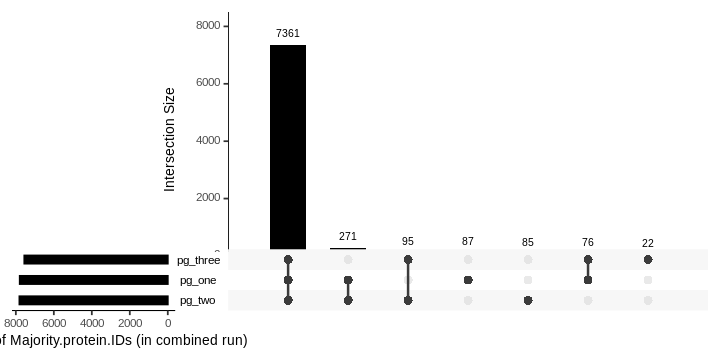

In [223]:
all_elements <- unique(c(pg_one, pg_two, pg_three))

data <- data.frame(element = all_elements,
                   pg_one = as.integer(all_elements %in% pg_one),
                   pg_two = as.integer(all_elements %in% pg_two),
                   pg_three = as.integer(all_elements %in% pg_three))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("pg_one", "pg_two", "pg_three"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of Majority.protein.IDs (in combined run)",
        )

In [207]:
for(seq in all_elements) {
  if(grepl("[^ARNDCEQGHILKMFPSTWYV]", seq)) {
    print(seq)
  }
}

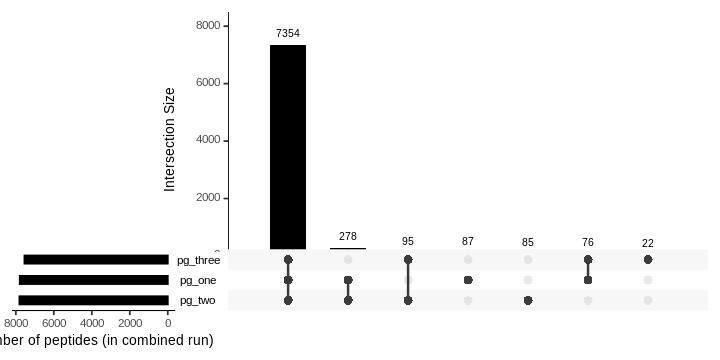

In [208]:
all_elements <- unique(c(pg_one, pg_two, pg_three))

data <- data.frame(element = all_elements,
                   pg_one = as.integer(all_elements %in% pg_one),
                   pg_two = as.integer(all_elements %in% pg_two),
                   pg_three = as.integer(all_elements %in% pg_three))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("pg_one", "pg_two", "pg_three"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of peptides (in combined run)",
        )

In [209]:
# pg_intensities %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/pg_intensities_combined.tsv",
#                                sep = "\t", quote = FALSE, row.names = TRUE)

# rownames(metadata) <- metadata$Quantitative.column.name
# metadata %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/metadata_combined.tsv",
#                             sep = "\t", quote = FALSE, row.names = FALSE)
    

#### Gene.names

In [210]:
# take only the columns that we need
pg_intensities <- PG_report %>%
    select(c("Gene.names", rownames(metadata))) 
colnames(pg_intensities) <- c("Gene.names", metadata$Quantitative.column.name)
dim(pg_intensities)


# remove rows with all values are zeros
pg_intensities[pg_intensities==0] <- NA
# count the % of missing values
round(sum(is.na(pg_intensities)) * 100 / (dim(pg_intensities)[1] * dim(pg_intensities)[2]), 3)


[1] 768  66

[1] 24.473

In [211]:
pg_intensities_center_one <- pg_intensities %>%
    select(c("Gene.names", metadata[metadata$Center == 'Center1',]$Quantitative.column.name))
dim(pg_intensities_center_one)
pg_intensities_center_one <- pg_intensities_center_one %>%
    # filter rows that have all values missing - at leat two values are present
    filter(rowSums(is.na(.)) < (dim(.)[2] - 2))
dim(pg_intensities_center_one)

pg_intensities_center_two <- pg_intensities %>%
    select(c("Gene.names", metadata[metadata$Center == 'Center2',]$Quantitative.column.name)) %>%
    # filter rows that have all values missing
    filter(rowSums(is.na(.)) < (dim(.)[2] - 2))

pg_intensities_center_three <- pg_intensities %>%
    select(c("Gene.names", metadata[metadata$Center == 'Center3',]$Quantitative.column.name)) %>%
    # filter rows that have all values missing
    filter(rowSums(is.na(.)) < (dim(.)[2] - 2))


[1] 768  23

[1] 664  23

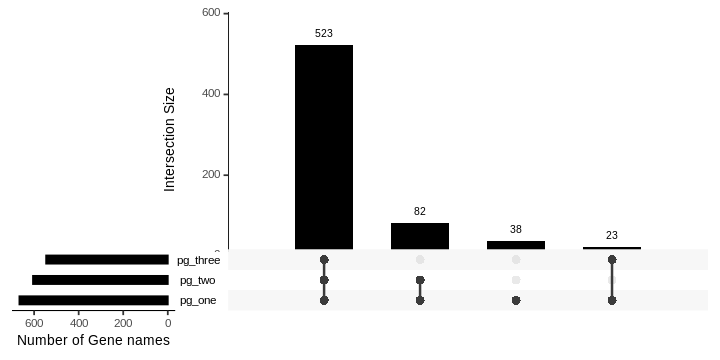

In [212]:
gene_one <- unique(unlist(strsplit(filter(pg_intensities_center_one, Gene.names != '')$Gene.names, ";")))
gene_two <- unique(unlist(strsplit(filter(pg_intensities_center_two, Gene.names != '')$Gene.names, ";")))
gene_three <- unique(unlist(strsplit(filter(pg_intensities_center_three, Gene.names != '')$Gene.names, ";")))

all_elements <- unique(c(gene_one, pg_two, pg_three))

data <- data.frame(element = all_elements,
                   pg_one = as.integer(all_elements %in% gene_one),
                   pg_two = as.integer(all_elements %in% gene_two),
                   pg_three = as.integer(all_elements %in% gene_three))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("pg_one", "pg_two", "pg_three"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of Gene names",
        )

In [ ]:
gene_one <- unique(filter(pg_intensities_center_one, Gene.names != '')$Gene.names)
gene_two <- unique(filter(pg_intensities_center_two, Gene.names != '')$Gene.names)
gene_three <- unique(filter(pg_intensities_center_three, Gene.names != '')$Gene.names)

all_elements <- unique(c(gene_one, pg_two, pg_three))

data <- data.frame(element = all_elements,
                   pg_one = as.integer(all_elements %in% gene_one),
                   pg_two = as.integer(all_elements %in% gene_two),
                   pg_three = as.integer(all_elements %in% gene_three))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("pg_one", "pg_two", "pg_three"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of Gene names",
        )

#### counts

In [9]:
pg_counts <- PG_report %>%
    select(c("Protein.IDs", "Razor...unique.peptides")) 
rownames(pg_counts) <- pg_counts$Protein.IDs
pg_counts$Protein.IDs <- NULL

pg_counts <- pg_counts + 1

dim(pg_counts)

pg_counts %>% write.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/pg_counts_combined.tsv",
                               sep = "\t", quote = FALSE, row.names = TRUE)

[1] 666   1

# EDA combined data

## plots

In [10]:
pca_plot <- function(df, batch_info, title, path) {
  pca <- prcomp(t(na.omit(df)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column("Quantitative.column.name") %>% 
    left_join(batch_info,  by = "Quantitative.column.name") 
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Group, shape=Center), size=3)  +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

   # Check if "RIC_3.P_3" exists in the pca_df dataframe
  if("RIC_3.P_3" %in% pca_df$Quantitative.column.name) {
    pca_plot <- pca_plot +
      geom_text(data = pca_df[pca_df$Quantitative.column.name == "RIC_3.P_3", ], aes(label = Quantitative.column.name), 
                vjust = 1, hjust = 0)
  }
  ggsave(path, pca_plot, width = 5, height = 5)
  return(pca_plot)
}


# boxplot
boxplot_pg <- function(protein_matrix, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "file", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = file, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 3, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    # adjust fonsize for the x-axis
    theme(axis.text.x = element_text(size = 8)) +
    labs(title = title) 

  if(path == "") {
    return(boxplot)
  } else {
      ggsave(path, boxplot)
      return(boxplot)
  }

}


heatmap_plot <- function(pg_matrix, batch_info, name, plot_name_prefix){
    cor_matrix <- cor(na.omit(pg_matrix), use = "pairwise.complete.obs")
    pheatmap::pheatmap(cor_matrix, 
                        annotation_col = select(batch_info, c(Group, Center)),
                        treeheight_row = 0, treeheight_col = 0, 
                        main = paste0(name),
                        fontsize = 8,
                        width = 8, height = 7,
                        filename = paste0(plot_name_prefix, "_heatmap.png"))
}



In [11]:
plot_three_in_one <- function(pg_matrix, metadata, name, plot_name_prefix) {

    pca <- pca_plot(pg_matrix, metadata, paste0(name, ' pca'), paste0(plot_name_prefix, '_pca.png'))
    box <- boxplot_pg(pg_matrix, paste0(name, ' boxplot'), paste0(plot_name_prefix, '_boxplot.png'))
    heatmap_plot(pg_matrix, metadata, name, plot_name_prefix)
    
    combined_plot <- plot_grid(pca, box, ncol = 1, align = "v")

    # Save the combined plot
    ggsave(paste0(plot_name_prefix, "_combined_two.png"), combined_plot, width = 8, height = 11)
}

## results

In [12]:
metadata <- metadata %>%
    mutate(Group = as.factor(Group), Center = as.factor(Center), Reporter.ion = as.factor(Reporter.ion)) %>%
    mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

In [13]:
plot_three_in_one(log2(pg_intensities + 1),
                  metadata,
                  "TMT-data, raw protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/01_pg_intensities_raw_log")
                  

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [14]:
head(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<fct>,<chr>,<fct>,<fct>
P_1.RIC_1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
P_1.RIC_2,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
P_1.RIC_3,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1
P_1.RIC_4,P_1.RIC_4,Pool1,128N,heathy2,heathy,Center1
P_1.RIC_5,P_1.RIC_5,Pool1,128C,FSGS2,FSGS,Center1
P_1.RIC_6,P_1.RIC_6,Pool1,129N,heathy3,heathy,Center1


In [15]:
# print(format(round(colSums(pg_intensities, na.rm = TRUE), digits = 0), big.mark = ","))

# the same using tidyverse and summarize function
pg_intensities %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,160719146,293819.3
Center1,Pool2,147686435,287327.7
Center2,Pool3,418114201,802820.2
Center2,Pool5,388265344,679974.3
Center3,Pool4,2025653562,4598472.4
Center3,Pool6,2605146812,5354713.1


# Normalization

### Methods

!!!!!!!!!!!!!!!!!!!!! Contains bugs!

In [16]:
iRS_function <- function(df, metadata, sample_column = 'Quantitative.column.name',
                         group_column = 'Group', reference_name = 'Common Reference',
                         pool_column = 'Pool', batch_column = 'Center') {
  
  df <- df %>% rownames_to_column("Protein.IDs")
  
  # Convert to long format while preserving the protein identifier
  df_long <- pivot_longer(df, cols = -Protein.IDs, names_to = sample_column, values_to = "Value")
  
  # Merge long format data with metadata
  df_long <- left_join(df_long, metadata, by = sample_column)
  
  # Isolate 'Common Reference' samples and ensure calculations are per protein within each center
  common_refs <- df_long %>% 
    filter(!!sym(group_column) == reference_name) %>%
    select(-!!sym(group_column), -!!sym(sample_column))
  
  # Compute the geometric mean of 'Common Reference' across all plexes for each protein within each center
  common_geo_mean <- common_refs %>%
    group_by(Protein.IDs, !!sym(batch_column)) %>%
    # group_by(Protein.IDs) %>%
    summarise(OverallGeoMean = exp(mean(log(Value), na.rm = TRUE)), .groups = 'drop')
    # summarise(OverallGeoMean = exp(mean(log(Value))), .groups = 'drop')


  # Calculate IRS factors for each 'Common Reference' in each plex, per protein, within each center
  irs_factors <- common_refs %>%
    left_join(common_geo_mean, by = c("Protein.IDs", batch_column)) %>%
    # left_join(common_geo_mean, by = c("Protein.IDs")) %>%
    group_by(!!sym(pool_column), Protein.IDs, !!sym(batch_column)) %>%
    # group_by(!!sym(pool_column), Protein.IDs) %>%
    summarise(IRSFactor = OverallGeoMean / mean(Value), .groups = 'drop')
  
  # Apply IRS scaling to all samples in each plex, per protein, within each center
  df_scaled <- df_long %>%
    left_join(irs_factors, by = c(pool_column, "Protein.IDs", batch_column)) %>%
    # left_join(irs_factors, by = c(pool_column, "Protein.IDs")) %>%
    mutate(ScaledValue = ifelse(is.na(IRSFactor), Value, Value * IRSFactor))
  
  # Pivot back to wide format if necessary, with proteins as rows and samples as columns
  df_final <- pivot_wider(df_scaled, names_from = sample_column, values_from = ScaledValue, id_cols = "Protein.IDs") %>%
    column_to_rownames("Protein.IDs")
  
  return(df_final)
}



median_noramlization <- function(df, log_normalized = FALSE) {
  if(!log_normalized) {
    df <- log2(df + 1)
  }
  medians <- apply(df, 2, median, na.rm = TRUE)
  normalized_df <- sweep(df, 2, medians, FUN="/")
  mean_of_medians <- mean(medians, na.rm=TRUE)
  normalized_df <- as.data.frame(normalized_df * mean_of_medians)

  return(normalized_df)
}

sample_load_norm <- function(data_raw, metadata){

  # Ensure column names from data_raw match the Quantitative.column.name names in metadata
  data_raw <- data_raw[, metadata$Quantitative.column.name]
  
  # Initialize an empty list to store split experiments
  experiments_raw <- list()
  
  # Separate data_raw based on Pool information in metadata
  unique_pools <- unique(metadata$Pool)
  for (i in 1:length(unique_pools)) {
    pool_samples <- metadata$Quantitative.column.name[metadata$Pool == unique_pools[i]]
    experiments_raw[[i]] <- data_raw[, pool_samples, drop = FALSE]
  }
  
  # Initialize an empty list for storing normalized data
  experiments_sl <- list()
  
  # Calculate the target for normalization
  target <- mean(unlist(sapply(experiments_raw, function(exp) colSums(exp, na.rm = TRUE))))
  
  # Normalize each experiment
  for (i in 1:length(experiments_raw)) {
    norm_facs <- target / colSums(experiments_raw[[i]], na.rm = TRUE)
    experiments_sl[[i]] <- sweep(experiments_raw[[i]], 2, norm_facs, FUN = "*")
  }
  
  # Combine normalized data from all experiments
  data_sl <- do.call(cbind, experiments_sl)
  
  return(as.data.frame(data_sl))

}

### iRS - Median - BEC

In [17]:
intensities_scaled <- iRS_function(pg_intensities, metadata)

dim(intensities_scaled)
round(sum(is.na(intensities_scaled)) * 100 / (dim(intensities_scaled)[1] * dim(intensities_scaled)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, iRS-scaled protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/02_pg_intensities_scaled_log")
                  

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(sample_column)

  # Now:
  data %>% select(all_of(sample_column))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [18]:
intensities_scaled %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.


`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,154202412,281905.7
Center1,Pool2,154436630,300460.4
Center2,Pool3,405178100,777981.3
Center2,Pool5,401299412,702801.1
Center3,Pool4,2244488256,5095113.2
Center3,Pool6,2357666715,4846036.1


In [19]:
intensities_scaled_norm <- median_noramlization(intensities_scaled, log_normalized = FALSE)

dim(intensities_scaled_norm)
round(sum(is.na(intensities_scaled_norm)) * 100 / (dim(intensities_scaled_norm)[1] * dim(intensities_scaled_norm)[2]), 3)

plot_three_in_one(intensities_scaled_norm,
                  metadata,
                  "TMT, iRScaled, Median norm intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/03_pg_intensities_scaled_norm_log")

[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [20]:
intensities_scaled_norm %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.


`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,9137.713,16.70514
Center1,Pool2,8538.524,16.61191
Center2,Pool3,8649.508,16.60812
Center2,Pool5,9474.561,16.59293
Center3,Pool4,7394.563,16.78857
Center3,Pool6,8222.081,16.89890


In [21]:
# bacth effects correction

design <- model.matrix(~0 + metadata$Group)
corrected_sl_irs <- limma::removeBatchEffect(intensities_scaled_norm, 
    batch2 = metadata$Pool, 
    design = design)



dim(corrected_sl_irs)
round(sum(is.na(corrected_sl_irs)) * 100 / (dim(corrected_sl_irs)[1] * dim(corrected_sl_irs)[2]), 3)

plot_three_in_one(as.data.frame(corrected_sl_irs),
                  metadata,
                  "TMT, iRScaled, Median norm, BEC intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/04_pg_intensities_scaled_norm_log_BEC")

Warning message:
“Partial NA coefficients for 296 probe(s)”


[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”


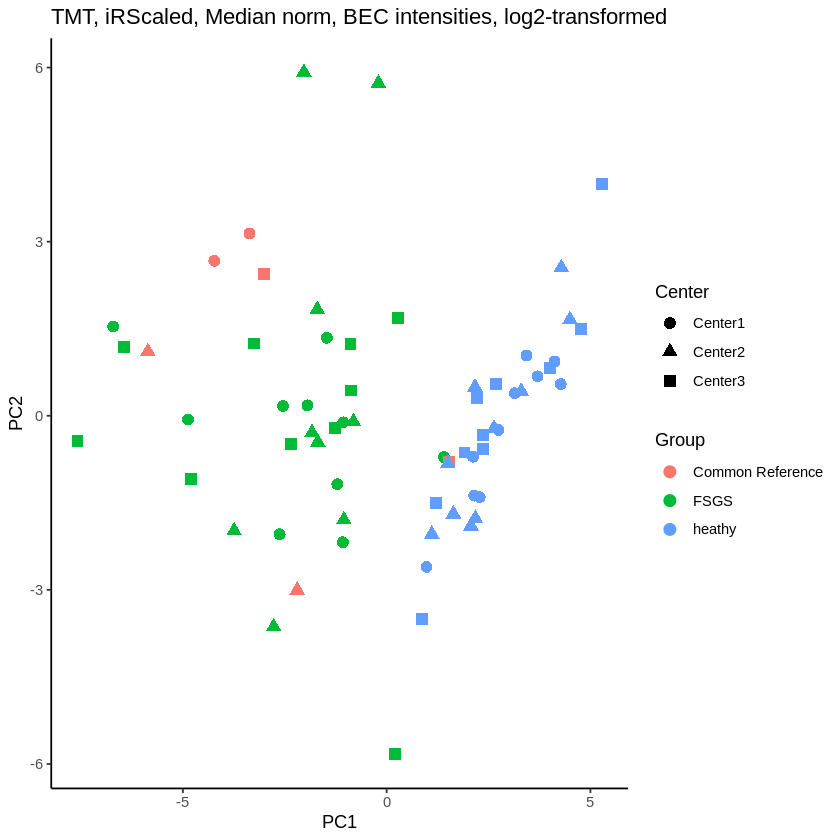

In [ ]:

  pca <- prcomp(t(na.omit(corrected_sl_irs)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column("Quantitative.column.name") %>% 
    left_join(metadata,  by = "Quantitative.column.name") 
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Group, shape=Center), size=3)  +
    theme_classic() +
    labs(title = "TMT, iRScaled, Median norm, BEC intensities, log2-transformed")
  

### SL - iRS - BEC

In [ ]:
intensities_sl <- sample_load_norm(pg_intensities, metadata)

dim(intensities_sl)
round(sum(is.na(intensities_sl)) * 100 / (dim(intensities_sl)[1] * dim(intensities_sl)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, SL-norm protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/02_pg_intensities_scaled_log")
                  

[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [ ]:
intensities_sl %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,965897328,1765809
Center1,Pool2,965897328,1879178
Center2,Pool3,965897328,1854643
Center2,Pool5,965897328,1691589
Center3,Pool4,965897328,2192969
Center3,Pool6,965897328,1985228


In [ ]:
intensities_scaled <- iRS_function(intensities_sl, metadata)

dim(intensities_scaled)
round(sum(is.na(intensities_scaled)) * 100 / (dim(intensities_scaled)[1] * dim(intensities_scaled)[2]), 3)

plot_three_in_one(log2(intensities_scaled + 1),
                  metadata,
                  "TMT, SL, iRS-scaled protein intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/03_pg_intensities_SL_scaled_log")
                  

[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


In [ ]:
intensities_scaled %>%
    # summarize(across(everything(), ~sum(., na.rm = TRUE))) %>%
    pivot_longer(cols = everything(), 
                 names_to = "Quantitative.column.name", 
                 values_to = "Value") %>%
    na.omit() %>%
    left_join(select(metadata, c(Quantitative.column.name, Pool, Center)), by = 'Quantitative.column.name') %>%
    group_by(Center, Pool, Quantitative.column.name) %>%
    summarize(sum = sum(Value, na.rm = TRUE), mean = mean(Value, na.rm = TRUE)) %>%
    group_by(Center, Pool) %>%
    summarise(mean_sample_sum = mean(sum), mean_sample_mean = mean(mean))

`summarise()` has grouped output by 'Center', 'Pool'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Center'. You can override using the
`.groups` argument.


Center,Pool,mean_sample_sum,mean_sample_mean
<fct>,<chr>,<dbl>,<dbl>
Center1,Pool1,967948245,1769558
Center1,Pool2,966982277,1881288
Center2,Pool3,968599906,1859831
Center2,Pool5,965190890,1690352
Center3,Pool4,963626122,2187756
Center3,Pool6,969858563,1993371


In [ ]:
# bacth effects correction

design <- model.matrix(~0 + metadata$Group)
corrected_sl_irs <- limma::removeBatchEffect(log2(intensities_scaled + 1), 
    batch2 = metadata$Pool, 
    design = design)



dim(corrected_sl_irs)
round(sum(is.na(corrected_sl_irs)) * 100 / (dim(corrected_sl_irs)[1] * dim(corrected_sl_irs)[2]), 3)

plot_three_in_one(as.data.frame(corrected_sl_irs),
                  metadata,
                  "TMT, SL, iRScaled, BEC intensities, log2-transformed",
                  "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/balanced_data/combined_plots/04_pg_intensities_SL_scaled_log_BEC")

Warning message:
“Partial NA coefficients for 296 probe(s)”


[1] 660  65

[1] 22.245

Saving 6.67 x 6.67 in image
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 9543 rows containing non-finite values (`stat_summary()`).”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


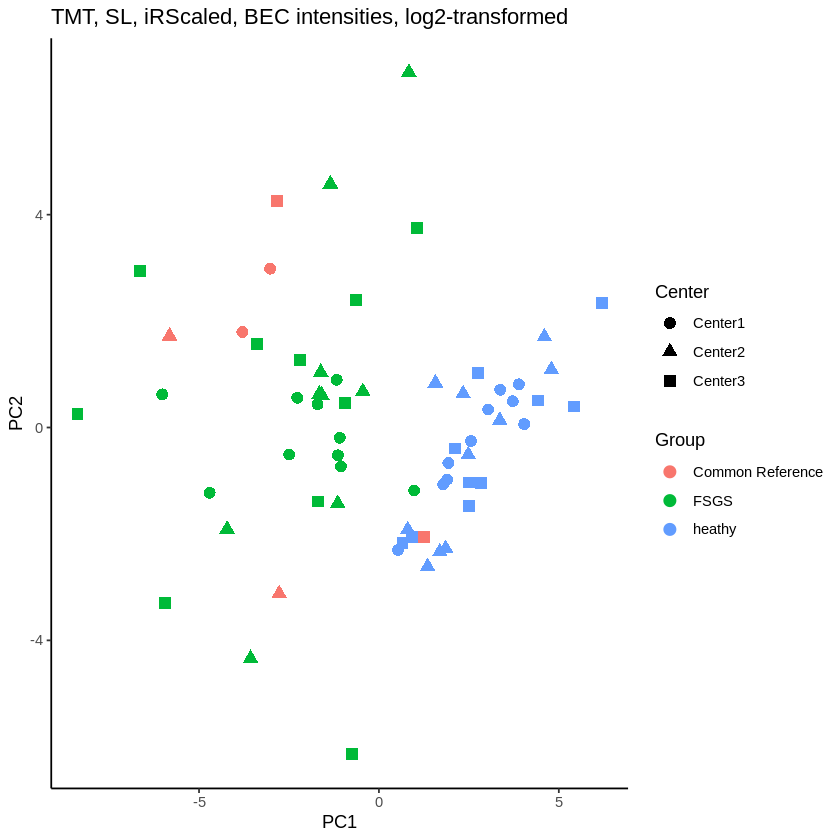

In [ ]:

  pca <- prcomp(t(na.omit(corrected_sl_irs)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column("Quantitative.column.name") %>% 
    left_join(metadata,  by = "Quantitative.column.name") 
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=Group, shape=Center), size=3)  +
    theme_classic() +
    labs(title = "TMT, SL, iRScaled, BEC intensities, log2-transformed")
  

# Peptides

In [224]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))


head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

In [225]:
preprocess_mxout <- function(path, center_metadata){
    PG_report <- read.table(
        path,
        header=T,
        sep="\t",
        stringsAsFactors = F)
    
    # # remove decoy matches and matches to contaminant
    # PG_report <- PG_report[!PG_report$Reverse=="+",]
    # PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
    # # if the PG_report$Only.identified.by.site is not all NA and contains "+" values - remove this rows
    # if(!all(is.na(PG_report$Only.identified.by.site))) {
    #     # # Only.identified.by.site - exclude proteins that were only identified by a modification site
    #     PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]
    # }

    # take only the columns that we need
    pg_intensities <- PG_report %>%
        select(c("Sequence", rownames(center_metadata)))

    print(length(pg_intensities$Sequence))

    # counts
    # pg_counts <- PG_report %>%
    #     select(c("Majority.protein.IDs", "Razor...unique.peptides")) 
    # rownames(pg_counts) <- pg_counts$Majority.protein.IDs
    # pg_counts$Majority.protein.IDs <- NULL
    # pg_counts <- pg_counts + 1
    # return(list(pg_intensities, pg_counts))
    return(pg_intensities)
}

In [226]:
peptides_df <- preprocess_mxout("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Combined/peptides.txt", metadata)
peptides_df <- peptides_df[, c("Sequence", rownames(metadata))]
colnames(peptides_df) <- c("Sequence", metadata$Quantitative.column.name)
dim(peptides_df)
head(peptides_df, 3)

[1] 8008


[1] 8008   66

,Sequence,P_1.RIC_1,P_1.RIC_2,P_1.RIC_3,P_1.RIC_4,P_1.RIC_5,P_1.RIC_6,P_1.RIC_7,P_1.RIC_8,P_1.RIC_9,⋯,P_6.RIC_2,P_6.RIC_3,P_6.RIC_4,P_6.RIC_5,P_6.RIC_6,P_6.RIC_7,P_6.RIC_8,P_6.RIC_9,P_6.RIC_10,P_6.RIC_11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAAATGTIFTFR,9932.8,10121,10191,4770.3,8109.8,12217.0,12637.0,7853.4,12351,⋯,0,0,0,0,0,0,0,0,0,0
2,AAAEVAGQFVIK,10290.0,12784,10758,11639.0,28589.0,8405.1,9419.1,11465.0,12787,⋯,47269,35796,42466,38417,31251,73083,39171,36858,35040,34171
3,AAALAHLDR,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [227]:
# take only the columns that we need
rownames(peptides_df) <- peptides_df$Sequence
peptides_df$Sequence <- NULL


peptides_df[peptides_df==0] <- NA
# count the % of missing values
round(sum(is.na(peptides_df)) * 100 / (dim(peptides_df)[1] * dim(peptides_df)[2]), 3)


[1] 36.101

In [228]:
pg_intensities_center_one <- peptides_df %>%
    select(metadata[metadata$Center == 'Center1',]$Quantitative.column.name)
dim(pg_intensities_center_one)
pg_intensities_center_one <- pg_intensities_center_one %>%
    # filter rows that have all values missing - at leat two values are present
    filter(rowSums(is.na(.)) < (dim(.)[2] - 1))
dim(pg_intensities_center_one)

pg_intensities_center_two <- peptides_df %>%
    select(metadata[metadata$Center == 'Center2',]$Quantitative.column.name) %>%
    # filter rows that have all values missing
    filter(rowSums(is.na(.)) < (dim(.)[2] - 1))

pg_intensities_center_three <- peptides_df %>%
    select(metadata[metadata$Center == 'Center3',]$Quantitative.column.name) %>%
    # filter rows that have all values missing
    filter(rowSums(is.na(.)) < (dim(.)[2] - 1))


[1] 8008   22

[1] 5801   22

In [229]:
pg_one <- unique(unlist(strsplit(rownames(pg_intensities_center_one), ";")))
length(pg_one)

pg_two <- unique(unlist(strsplit(rownames(pg_intensities_center_two), ";")))
length(pg_two)

pg_three <- unique(unlist(strsplit(rownames(pg_intensities_center_three), ";")))
length(pg_three)

common_proteins <- intersect(pg_one, pg_two) %>% intersect(pg_three) 
length(common_proteins)

[1] 5801

[1] 6230

[1] 5263

[1] 4128

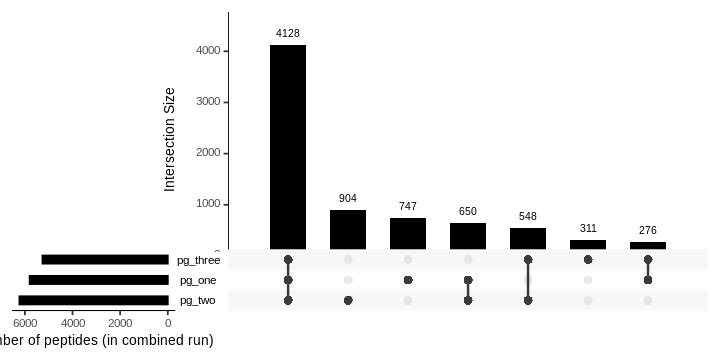

In [230]:
all_elements_pep <- unique(c(pg_one, pg_two, pg_three))

data <- data.frame(element = all_elements_pep,
                   pg_one = as.integer(all_elements_pep %in% pg_one),
                   pg_two = as.integer(all_elements_pep %in% pg_two),
                   pg_three = as.integer(all_elements_pep %in% pg_three))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("pg_one", "pg_two", "pg_three"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of peptides (in combined run)",
        )

In [231]:
for(seq in all_elements) {
  if(grepl("[^ARNDCEQGHILKMFPSTWYV]", seq)) {
    print(seq)
  }
}

In [232]:
length(all_elements_pep)
length(all_elements)

[1] 7564

[1] 7997

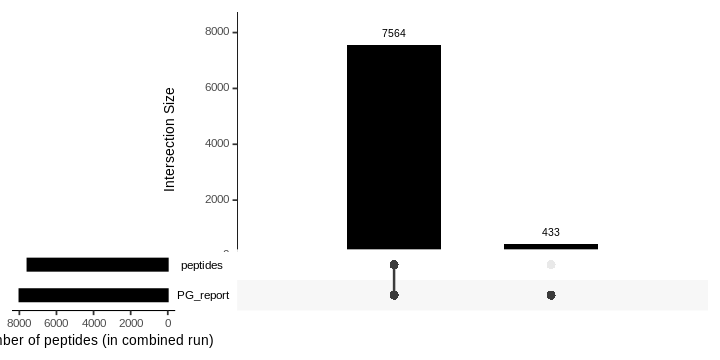

In [233]:
all_elements_comb <- unique(c(all_elements_pep, all_elements))

data <- data.frame(element = all_elements_comb,
                   PG_report = as.integer(all_elements_comb %in% all_elements),
                   peptides = as.integer(all_elements_comb %in% all_elements_pep))

options(repr.plot.width=6, repr.plot.height=3)
upset(data, sets = c("PG_report", "peptides"), order.by = "freq",
        # add title to the whole plot

        main.bar.color = "black",
        sets.bar.color = "black",
        sets.x.label = "Number of peptides (in combined run)",
        )

In [234]:
# print different peptides
setdiff(all_elements_pep, all_elements)

character(0)

In [235]:
# print different peptides
sort(setdiff(all_elements,all_elements_pep))

[1] "AAFNSGK"                      "AAMEPIVISAK"                 
  [3] "AAQGLLACGVAQGALR"             "AAYCACR"                     
  [5] "AEECYYDENVAR"                 "AEMLDHAVLLQVIK"              
  [7] "AETGDTVLK"                    "AEVSELK"                     
  [9] "AGLGEEFEK"                    "AGTPYTVTLHGEVR"              
 [11] "AHIPPLGLK"                    "AHSDGGDGVVSQVK"              
 [13] "AHTDVGPGPESSPVLVR"            "AICDHVR"                     
 [15] "AIFSVGPVSPSR"                 "AILQGAK"                     
 [17] "AINEKLGQYASPTAK"              "AIQDGTIVLMGTYDDGATK"         
 [19] "ALAPEYAK"                     "ALELEQERK"                   
 [21] "ALGLVPQAHPGFLTAWPADR"         "ALGQNPTNAEVLK"               
 [23] "ANHASSVPR"                    "APLPLGHIK"                   
 [25] "APLTKPLK"                     "APTAQVESFR"                  
 [27] "AQPENIPAK"                    "ARFEELNADLFR"                
 [29] "ARGPDSNVLLLR"                 "ASASDGSSFVVAR"               
 [31] "ASCCCSLGK"                    "ASCKVPVKK"                   
 [33] "ASFPIITVTAAHSGTYR"            "ASGPPVSELITK"                
 [35] "ASGSPEPAISWFR"                "ASIHEAWTDGK"                 
 [37] "ASLEGNLAETENR"                "ASLHGGEPTTIIR"               
 [39] "ASQSVSSSYLAWYQQK"             "ASQSVSSYLAWYQQK"             
 [41] "ASSVVVSGTPIR"                 "ASTSTTIRSHSSSR"              
 [43] "ASVDSGSSEEQGGSSR"             "ATEDEGSEQK"                  
 [45] "AVACTFAR"                     "AVASFLRR"                    
 [47] "AVPTGDASK"                    "AVTDEEPFLIFANR"              
 [49] "AVYEAVLR"                     "CAPGYTGDR"                   
 [51] "CCITAAPYR"                    "CDMEVSCPDGYTCCR"             
 [53] "CDSSPDSAEDVR"                 "CEFDINECK"                   
 [55] "CFQETIGSQCGK"                 "CPDEPAPR"                    
 [57] "CPTCPDACTFK"                  "CSCSSSSGLTCQAAGCPPGR"        
 [59] "CVPGEVEK"                     "CVPNSNER"                    
 [61] "CYDGYTLR"                     "DAFCVFEQNQGLPLR"             
 [63] "DANISQPETTKEGLR"              "DASIGTK"                     
 [65] "DATVACWELGCGK"                "DCGEEMQNGAGASR"              
 [67] "DCVGPEVEK"                    "DDQNPHSSNICNISCDK"           
 [69] "DFMIQGGDFTR"                  "DFVNASSK"                    
 [71] "DGIIVLK"                      "DGLAFNALIHR"                 
 [73] "DIEAQLQHAGLR"                 "DKVQYECATGYYTAGGK"           
 [75] "DLKPAIVK"                     "DLLQTVEDQYK"                 
 [77] "DLMVLNDVYR"                   "DMICAGEKEGGK"                
 [79] "DNVDDPTGNFR"                  "DPPEPGSPR"                   
 [81] "DPSLGAQFR"                    "DQCEDIDECQHR"                
 [83] "DQITCISK"                     "DQPGYSR"                     
 [85] "DRMYQMDIQQELQR"               "DSNRPSGIPER"                 
 [87] "DTIVFKCQK"                    "DVDNALR"                     
 [89] "DVGGQLQR"                     "DVHEGQPLLNVK"                
 [91] "DVLDGHLR"                     "EAAEGLR"                     
 [93] "EAEAASIK"                     "EAGAGGLAIAVEGPSK"            
 [95] "EDAGEYECHASNSQGQASASAK"       "EEEEETNR"                    
 [97] "EEFPFALGVQTLPQTCDEPK"         "EGAVLAK"                     
 [99] "EGLDLQVLEDSGR"                "EGSIWNHQPCFLK"               
[101] "EIGELYLPKFSISR"               "EIIDLVLDR"                   
[103] "EIIKPAEK"                     "EITENLMATGDLDQDGR"           
[105] "EIVNSLKK"                     "EKGEIQNILQK"                 
[107] "EKLTALTK"                     "EKLTALTKK"                   
[109] "ELAAQTIKK"                    "ELAEDGYSGVEVR"               
[111] "ELGCGGPQQPDPAAGR"             "ELISNASDALDK"                
[113] "ELLKDLSK"                     "ELTPQVVSAAR"                 
[115] "EMEMRQLQR"                    "ENDPVHGADGK"                 
[117] "ENFYQNWK"                     "EQLTPLIKK"          